### Constructing the Molecule

In [104]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="He 0 0 0; H+ 0 0 0.772",
    basis="sto-3g",
    charge=1,
    spin=0,
)

problem = driver.run()
print(problem)

### Converting to fermionic operator

In [105]:
fermionic_op = problem.hamiltonian.second_q_op()
print(fermionic_op)

Fermionic Operator
number spin orbitals=4, number terms=72
  -2.577728496435193 * ( +_0 -_0 )
+ 0.1729217600031944 * ( +_0 -_1 )
+ 0.17292176000319467 * ( +_1 -_0 )
+ -1.3474459268366916 * ( +_1 -_1 )
+ -2.577728496435193 * ( +_2 -_2 )
+ 0.1729217600031944 * ( +_2 -_3 )
+ 0.17292176000319467 * ( +_3 -_2 )
+ -1.3474459268366916 * ( +_3 -_3 )
+ 0.47157454307539015 * ( +_0 +_0 -_0 -_0 )
+ -0.08645994292809038 * ( +_0 +_0 -_1 -_0 )
+ -0.08645994292809038 * ( +_0 +_1 -_0 -_0 )
+ 0.3305728468222303 * ( +_0 +_1 -_1 -_0 )
+ 0.47157454307539015 * ( +_0 +_2 -_2 -_0 )
+ -0.08645994292809038 * ( +_0 +_2 -_3 -_0 )
+ -0.08645994292809038 * ( +_0 +_3 -_2 -_0 )
+ 0.3305728468222303 * ( +_0 +_3 -_3 -_0 )
+ -0.08645994292809038 * ( +_0 +_0 -_0 -_1 )
+ 0.07281896711907537 * ( +_0 +_0 -_1 -_1 )
+ 0.07281896711907537 * ( +_0 +_1 -_0 -_1 )
+ 0.018469323675948897 * ( +_0 +_1 -_1 -_1 )
+ -0.08645994292809038 * ( +_0 +_2 -_2 -_1 )
+ 0.07281896711907537 * ( +_0 +_2 -_3 -_1 )
+ 0.07281896711907537 * ( +_0 +_3 -_

In [106]:
print('spatial orbitals: ', problem.num_spatial_orbitals)
print('spin orbitals: ', problem.num_spin_orbitals)
print('num particles: ', problem.num_particles)


spatial orbitals:  2
spin orbitals:  4
num particles:  (1, 1)


### Jordan-Wigner Mapping 

In [107]:
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper

mapper = JordanWignerMapper()
qubit_jw_op = mapper.map(fermionic_op)
print(qubit_jw_op)

'''mapper2 = ParityMapper()
qubit_pm_op = mapper2.map(fermionic_op)
print(qubit_pm_op)'''

SparsePauliOp(['IIII', 'IIIZ', 'IIYY', 'IIXX', 'IIZI', 'IZII', 'YYII', 'XXII', 'ZIII', 'IIZZ', 'IZIZ', 'YYIZ', 'XXIZ', 'ZIIZ', 'IZYY', 'IZXX', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'ZIYY', 'ZIXX', 'IZZI', 'YYZI', 'XXZI', 'ZIZI', 'ZZII'],
              coeffs=[-2.91290137+0.j,  0.75891361+0.j,  0.05246557+0.j,  0.05246557+0.j,
  0.19140054+0.j,  0.75891361+0.j,  0.05246557+0.j,  0.05246557+0.j,
  0.19140054+0.j,  0.12887694+0.j,  0.23578727+0.j,  0.04322997+0.j,
  0.04322997+0.j,  0.16528642+0.j,  0.04322997+0.j,  0.04322997+0.j,
  0.03640948+0.j,  0.03640948+0.j,  0.03640948+0.j,  0.03640948+0.j,
 -0.00923466+0.j, -0.00923466+0.j,  0.16528642+0.j, -0.00923466+0.j,
 -0.00923466+0.j,  0.18815906+0.j,  0.12887694+0.j])


'mapper2 = ParityMapper()\nqubit_pm_op = mapper2.map(fermionic_op)\nprint(qubit_pm_op)'

### Two qubits reduction scheme

In [108]:
from qiskit.quantum_info import Z2Symmetries, SparsePauliOp
z2_symmetries = Z2Symmetries.find_z2_symmetries(qubit_jw_op)
#print(tqr_qubit_op)
reduced_qubit_op = z2_symmetries.taper(qubit_jw_op)


reduced_qubit_op = reduced_qubit_op[0]

print(reduced_qubit_op)

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[-2.65514749+0.j,  0.95031416+0.j,  0.95031416+0.j,  0.75451917+0.j])


### Constructing the Optimization Log

In [109]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

### Chosing the Optimization Method and Variational Form

/var/folders/dd/c1pbq9yj5qz5db5r7947bbvr0000gn/T/ipykernel_57154/2255010288.py:26: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), ansatz, optimizer=Optimizer,callback=log.update)


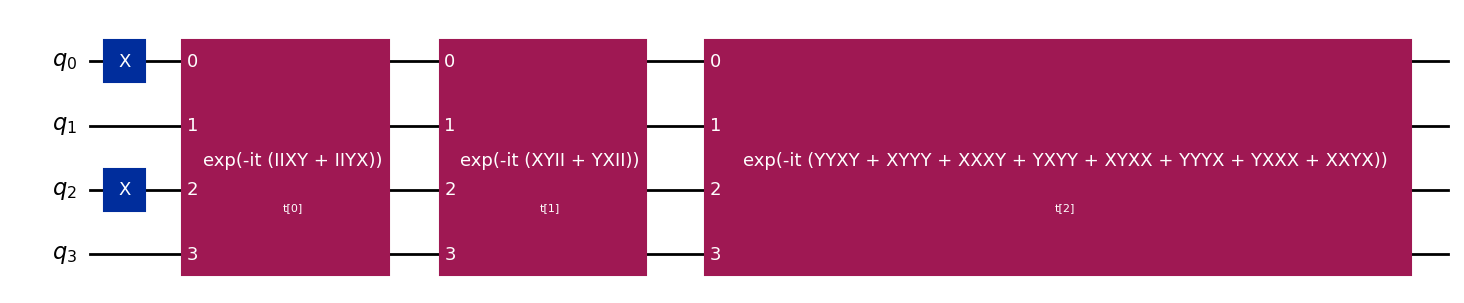

In [110]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP,SPSA,COBYLA, L_BFGS_B
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
import numpy as np
#this is the optimization method
log = OptimizerLog()
# Sequential Least Squares Programming

Optimizer = SLSQP()

# Using Unitary Coupled Cluster as Variational Form and HatreeFock for intial states 
# The Variation Form does affect the number parameters(theta) which also impact the number of iteration and expectation value (ground-state energy)
ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
    
)

vqe_solver = VQE(Estimator(), ansatz, optimizer=Optimizer,callback=log.update)

#Set the initial parameters(theta) as random - this will also affect the convergence of the plot and number of iteration.
#maybe we can a away to appoximate the intial points

vqe_solver.initial_point = np.random.random(ansatz.num_parameters)

ansatz.decompose().draw('mpl')

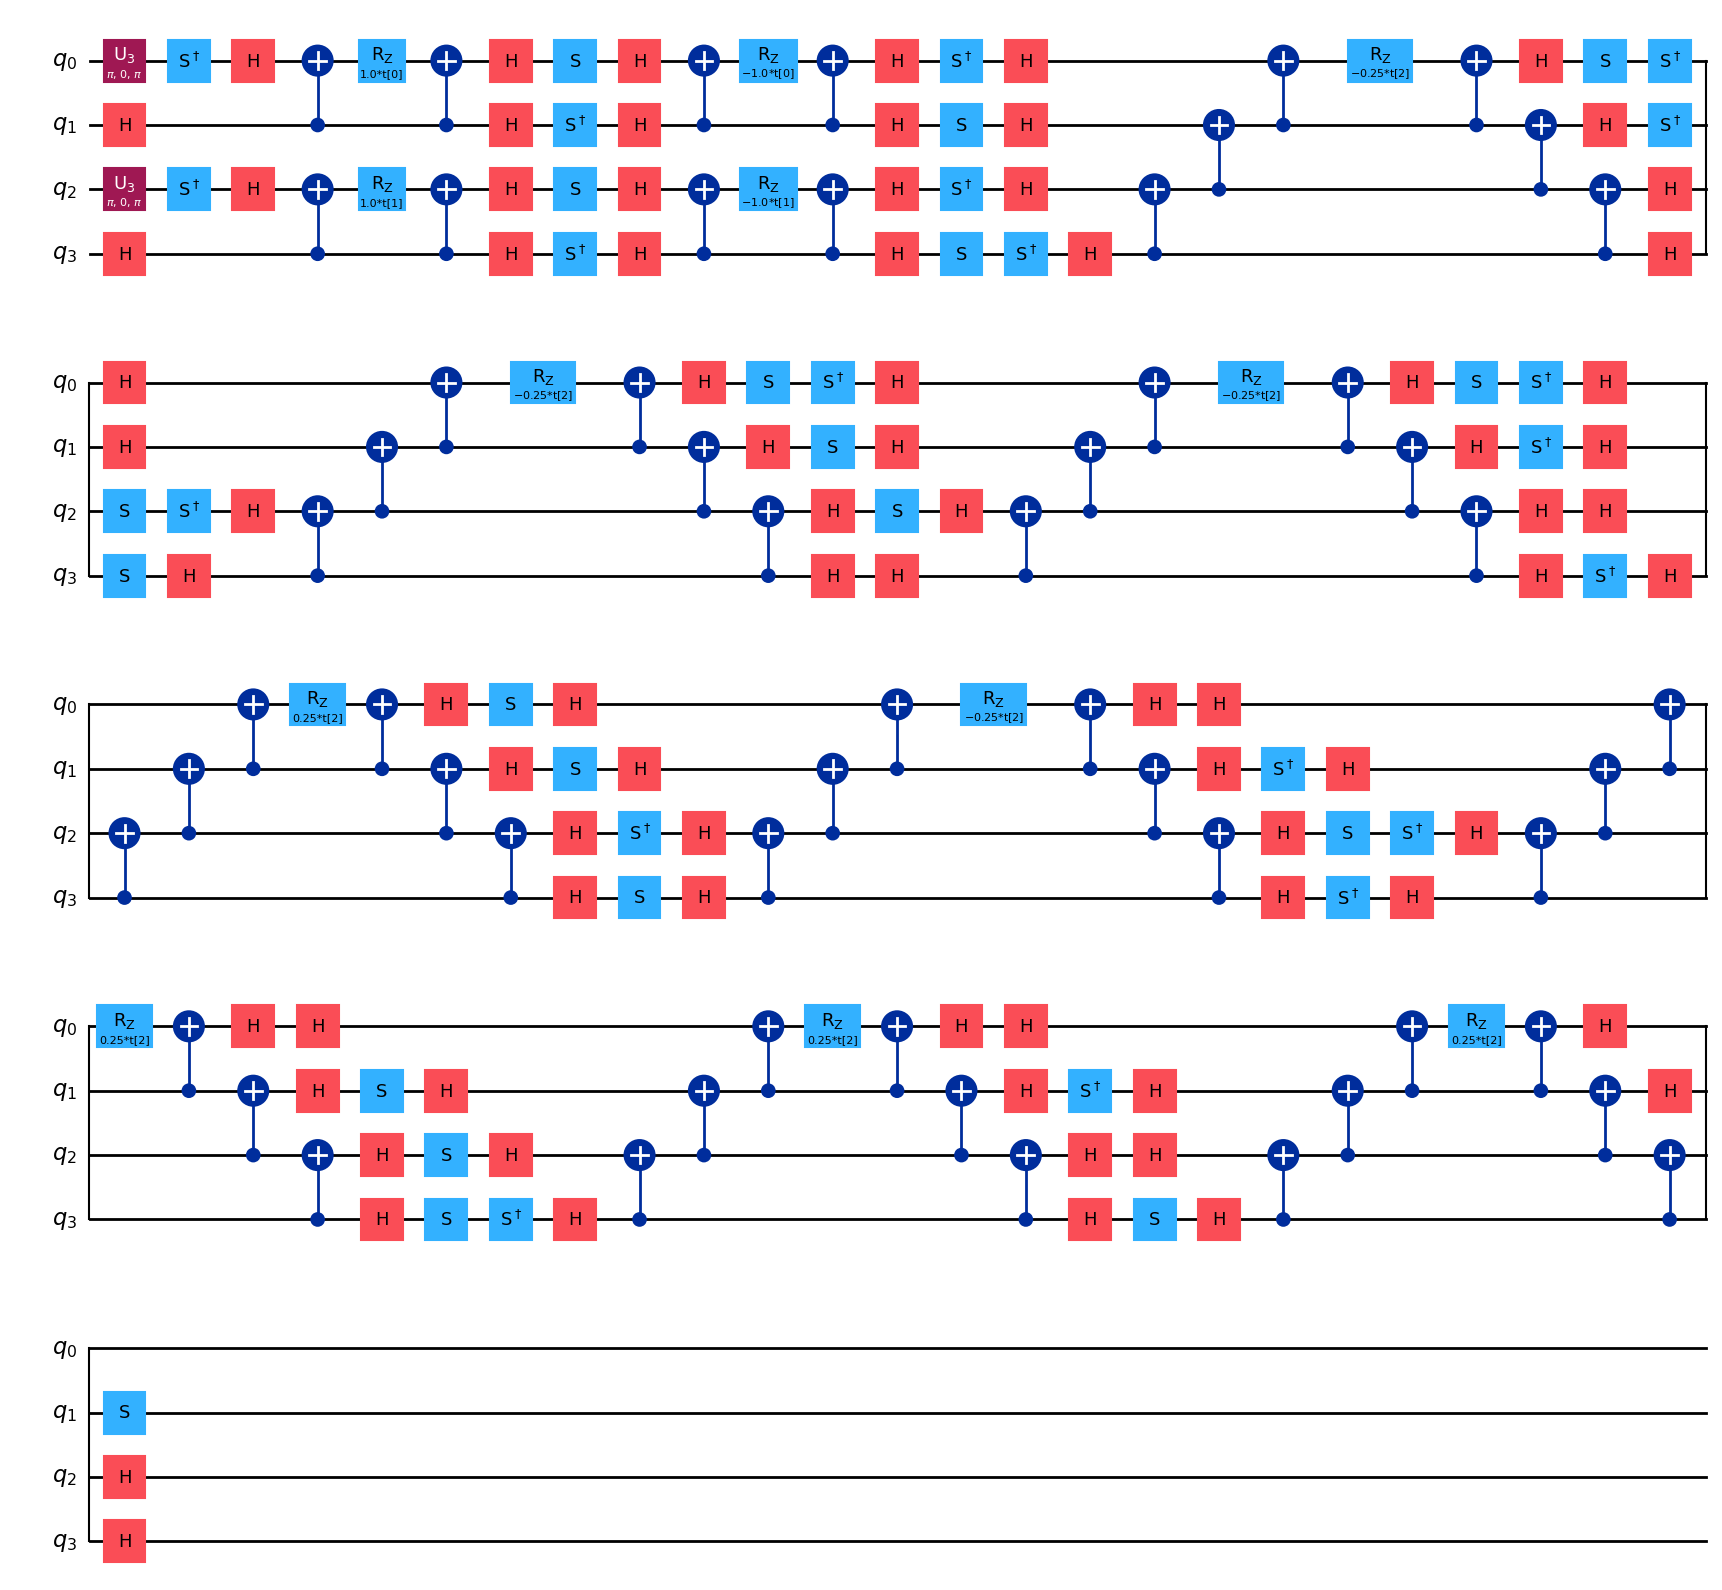

In [111]:
ansatz.decompose().decompose().draw('mpl')

### Solving the Ground-state energy

In [112]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
#from qiskit_aer import AerSimulator, Aer
calc = GroundStateEigensolver(mapper, vqe_solver)
res = calc.solve(problem)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -4.22194901087
  - computed part:      -4.22194901087
~ Nuclear repulsion energy (Hartree): 1.370925416891
> Total ground state energy (Hartree): -2.851023593978
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.45886857]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.385476859996]
    - computed part:      [0.0  0.0  0.385476859996]
  > Dipole moment (a.u.): [0.0  0.0  1.073391710004]  Total: 1.073391710004
                 (debye): [0.0  0.0  2.728289333348]  Total: 2.728289333348
 


### Ploting the Optimization value over iteration

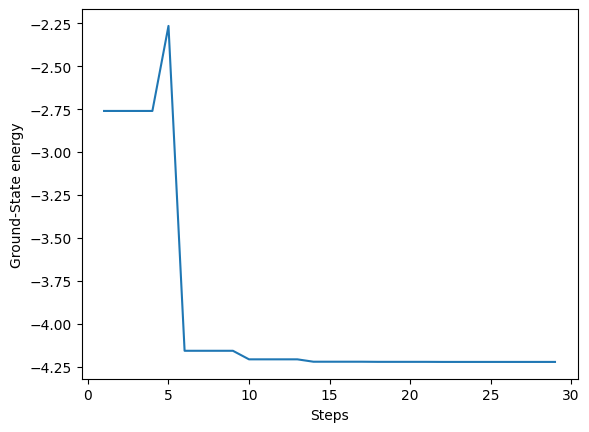

In [113]:
import matplotlib.pyplot as plt

figfig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Ground-State energy')
plt.show()

### Ploting the Paramaters(theta) over iteration

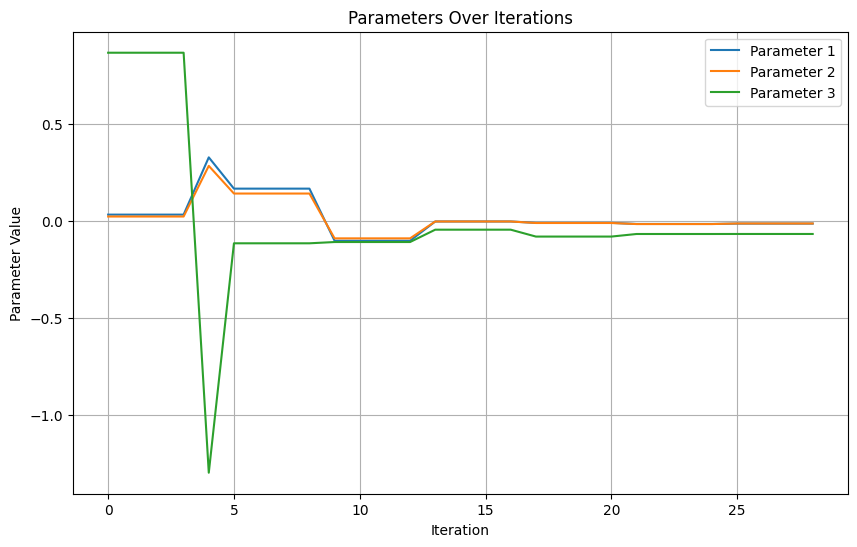

In [114]:
# Extract parameters
data = log.parameters
iterations = range(len(data))
param1 = [row[0] for row in data]
param2 = [row[1] for row in data]
param3 = [row[2] for row in data]

# Plotting the parameters
plt.figure(figsize=(10, 6))

plt.plot(iterations, param1, label='Parameter 1')
plt.plot(iterations, param2, label='Parameter 2')
plt.plot(iterations, param3, label='Parameter 3')

plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.title('Parameters Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [115]:
print('number of qubits: ', qubit_jw_op.num_qubits)
initial_state=HartreeFock(problem.num_spatial_orbitals, problem.num_particles, mapper)
print(initial_state)


number of qubits:  4
     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


### TwoLocal Ansazt

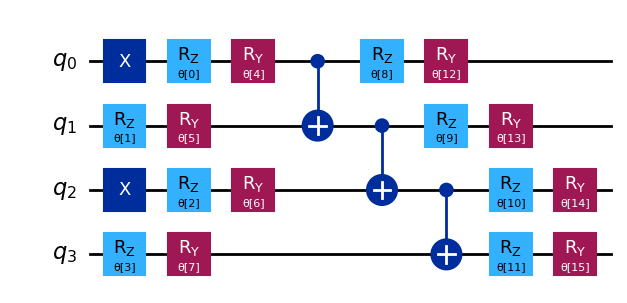

In [116]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
ansatz2 = TwoLocal(qubit_jw_op.num_qubits, rotation_blocks=['rz', 'ry'], entanglement_blocks='cx', entanglement='linear', reps=1, initial_state=HartreeFock(problem.num_spatial_orbitals, problem.num_particles, mapper))
ansatz2.decompose().draw('mpl')

In [117]:
log2 = OptimizerLog()
vqe_solver2 = VQE(Estimator(), ansatz2, optimizer=Optimizer,callback=log2.update)
vqe_solver2.initial_point = np.random.random(ansatz2.num_parameters)
calc2 = GroundStateEigensolver(mapper, vqe_solver2)
res2 = calc2.solve(problem)
print(res2)

/var/folders/dd/c1pbq9yj5qz5db5r7947bbvr0000gn/T/ipykernel_57154/3698376851.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver2 = VQE(Estimator(), ansatz2, optimizer=Optimizer,callback=log2.update)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -4.384408332973
  - computed part:      -4.384408332973
~ Nuclear repulsion energy (Hartree): 1.370925416891
> Total ground state energy (Hartree): -3.013482916081
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 3.000 S: 0.500 S^2: 0.750 M: -0.500
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.45886857]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.701342808313]
    - computed part:      [0.0  0.0  1.701342808313]
  > Dipole moment (a.u.): [0.0  0.0  -0.242474238313]  Total: 0.242474238313
                 (debye): [0.0  0.0  -0.616307981361]  Total: 0.616307981361
 


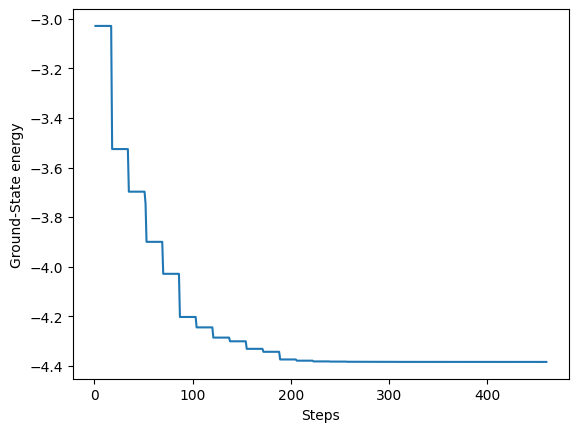

In [118]:
figfig = plt.figure()
plt.plot(log2.evaluations, log2.costs)
plt.xlabel('Steps')
plt.ylabel('Ground-State energy')
plt.show()

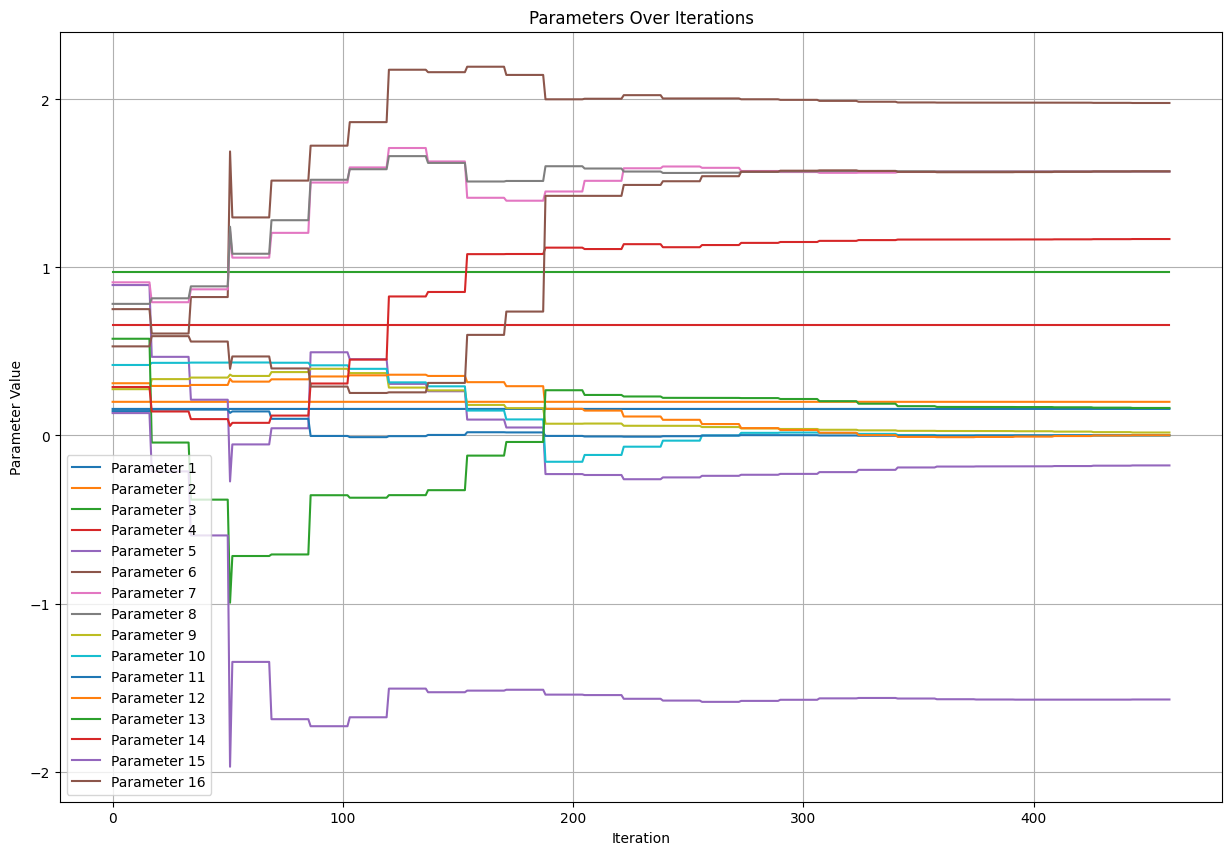

In [119]:
# Extract parameters
data2 = log2.parameters
iterations = range(len(data2))
# Extract all 16 parameters
parameters = [[row[i] for row in data2] for i in range(16)]
# Plotting the parameters
plt.figure(figsize=(15, 10))
# Plot each parameter
for i in range(16):
    plt.plot(iterations, parameters[i], label=f'Parameter {i+1}')

plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.title('Parameters Over Iterations')
plt.legend()
plt.grid(True)
plt.show()